In [1]:
import torch
from cirkit.templates import data_modalities, utils
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets


PIXEL_RANGE=255
example_image = None

KERNEL_SIZE=(4,4)
CIFAR_SIZE=(28,28)
DEVICE="cuda:6"
EPOCH=30

In [2]:

from cirkit.symbolic.layers import SumLayer, InputLayer
from cirkit.symbolic.parameters import TensorParameter, ReferenceParameter
from cirkit.symbolic.circuit import Circuit
from cirkit.utils.scope import Scope
from cirkit.symbolic.parameters import Parameter
from copy import copy 


def copy_parameter(graph:Parameter):
    new_param_nodes = []
    copy_map = {}
    in_nodes ={}
    outputs=[]
    for n in graph.topological_ordering():
        instance = type(n)
        if instance == TensorParameter:
            new_param = ReferenceParameter(n) 
        else:
            new_param = instance(**n.config)
        new_param_nodes.append(new_param)
        copy_map[n]=new_param
        inputs = [copy_map[in_node] for in_node in graph.node_inputs(n)]
        if len(inputs)>0:
            in_nodes[new_param]=inputs
    outputs = [copy_map[out_node] for out_node in graph.outputs]
    return Parameter(nodes=new_param_nodes, in_nodes=in_nodes, outputs=outputs)

def copy_circuit(graph:Circuit, scope_map:dict[int, int], root_node_outputs=None):
    new_circ_layers = []
    copy_map = {}
    in_nodes ={}
    outputs=[]
    copied_params=[]
    for layer in graph.topological_ordering():
        instance = type(layer)
        if isinstance(layer, SumLayer):
            if layer.weight in copied_params:
                parameter = copy_parameter(layer.weight)
            else:
                parameter=layer.weight
                copied_params.append(layer.weight)
            new_config = layer.config
            new_layer = SumLayer(
                **new_config,
                weight = parameter
                )
        if isinstance(layer, InputLayer):
            params = list(layer.params.items())
            p_key = params[0][0]
            p_graph = params[0][1]
            new_scope = Scope([scope_map[s] for s in layer.scope])
            config = copy(layer.config)
            del config["scope"]
            if p_graph in copied_params:
                new_p_graph = copy_parameter(p_graph)
            else:
                new_p_graph=p_graph
                copied_params.append(p_graph)
            new_layer = instance(scope= new_scope, **config, **{p_key:new_p_graph})
        else:
            new_config = layer.config
            new_layer = instance(**new_config, **layer.params)
        new_circ_layers.append(new_layer)
        copy_map[layer]=new_layer
        inputs = [copy_map[in_node] for in_node in graph.node_inputs(layer)]
        if len(inputs)>0:
            in_nodes[new_layer]=inputs
    outputs = [copy_map[out_node] for out_node in graph.outputs ]
    if root_node_outputs is not None:
        for n in outputs:
            n.num_output_units=root_node_outputs
    return new_circ_layers, in_nodes,outputs

def share_scope(big_circ:Circuit, share_small:Circuit, scope_size:int):
    layers= copy(big_circ.nodes)
    in_layers = copy(big_circ.nodes_inputs)
    layers_to_replace = []
    for n in big_circ.layerwise_topological_ordering():
        if len(big_circ.layer_scope(n[0]))==scope_size and isinstance(n[0], SumLayer):
            layers_to_replace = n
            break

    entry_points_map={}
    for l in layers_to_replace:
        for sl in big_circ.subgraph(l).topological_ordering():
            to_remove=[sl]
            while len(to_remove)>0:
                tr = to_remove.pop()
                if tr in in_layers:
                    to_remove.extend(in_layers[tr])
                    del in_layers[tr]
                if tr in layers:
                    layers.remove(tr)


        scope_map=dict(zip(share_small.scope, big_circ.layer_scope(l)))
        new_subgraph_layers, new_subgraph_inputs, new_output = copy_circuit(share_small, scope_map, root_node_outputs=sl.num_output_units)
        layers.extend(new_subgraph_layers)
        in_layers.update(new_subgraph_inputs)

        entry_points_map[sl]=new_output

    for old, new in entry_points_map.items():
        for node, inputs in in_layers.items():
            if old in inputs:
                in_layers[node].remove(old)
                in_layers[node].extend(new)


    return Circuit(
        layers = layers,
        in_layers=in_layers,
        outputs= big_circ.outputs
    )

## Data Preparation

Let's define a function to create and use patches of the base Dataset

In [3]:
def patchify(kernel_size, stride,compile=True, contiguous_output=False):
    kh, kw = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
    sh, sw = (stride, stride) if isinstance(stride, int) else stride
    def _patchify(image: torch.Tensor):
        # Accept (C,H,W) or (B,C,H,W)

        # Ensure contiguous NCHW for predictable strides
        x = image.contiguous()  # (B,C,H,W)
        B, C, H, W = x.shape

        # Number of patches along H/W
        Lh = (H - kh) // sh + 1
        Lw = (W - kw) // sw + 1

        # Create a zero-copy view: (B, C, Lh, Lw, kh, kw)
        sN, sC, sH, sW = x.stride()
        patches = x.as_strided(
            size=(B, C, Lh, Lw, kh, kw),
            stride=(sN, sC, sH * sh, sW * sw, sH, sW),
        )
        # Reorder to (B, P, C, kh, kw) where P = Lh*Lw
        patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(B * Lh * Lw, C, kh, kw)

        if contiguous_output:
            patches = patches.contiguous()  # materialize if the next ops need contiguous

        return patches
    if compile:
        _patchify = torch.compile(_patchify, fullgraph=True, dynamic=False)
    return _patchify

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (PIXEL_RANGE * x).long()),
])

data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

## Defining the Circuit

We want to create a factory to create the different circuit we will want to compare.

In [ ]:
def patch_circuit_factory(kernel_size, region_graph, layer_type, num_units, big_region_graph=None):
    shared_circ= data_modalities.image_data(
        (1,*kernel_size),
        region_graph=region_graph,
        input_layer="categorical",
        num_input_units=num_units,
        sum_product_layer=layer_type,
        num_sum_units=num_units,
        num_classes=num_units,
        sum_weight_param=utils.Parameterization(
                activation='softmax',   
                initialization='normal' 
            )
    )
    
    big_circ= data_modalities.image_data(
        (1,*CIFAR_SIZE),
        region_graph=big_region_graph if big_region_graph is not None else region_graph,
        input_layer="categorical",
        num_input_units=num_units,
        sum_product_layer=layer_type,
        num_sum_units=num_units,
        sum_weight_param=utils.Parameterization(
                activation='softmax',   
                initialization='normal' 
            )
    )

    return share_scope(big_circ, shared_circ, math.prod(kernel_size))

def base_circuit_factory(region_graph, layer_type, num_units):
    return data_modalities.image_data(
        (1,*CIFAR_SIZE),
        region_graph=region_graph,
        input_layer="categorical",
        num_input_units=num_units,
        sum_product_layer=layer_type,
        num_sum_units=num_units,
        sum_weight_param=utils.Parameterization(
                activation='softmax',   
                initialization='normal' 
            )
    )

In [11]:
circuits=dict()
circuits["patch + cp.T + quad-graph"] = patch_circuit_factory(KERNEL_SIZE, "quad-graph", "cp-t", 64)
circuits["patch + cp.T + quad-tree-2"] = patch_circuit_factory(KERNEL_SIZE, "quad-tree-2", "cp-t", 64)
circuits["base + cp + quad-graph"] = base_circuit_factory( "quad-graph", "cp", 64)
circuits["base + tucker + quad-graph"] = base_circuit_factory( "quad-graph", "tucker", 64)



## Training

In [9]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"

In [13]:
import random
import numpy as np
import pandas as pd
import time

from cirkit.pipeline import compile


def train_and_eval_circuit(cc,patch:bool):

    # Set some seeds
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    # torch.cuda.manual_seed(42)
    
    # Set the torch device to use
    device = torch.device(DEVICE)
    # device="cpu"
    # Move the circuit to chosen device
    circuit = compile(cc)
    circuit = circuit.to(device)
    
    num_epochs = EPOCH
    step_idx = 0
    running_loss = 0.0
    running_samples = 0
    stats = dict()

    stats['# trainable parameters'] = sum(p.numel() for p in circuit.parameters() if p.requires_grad)
    stats['train loss'] = []
    patch_fn=patchify(KERNEL_SIZE, KERNEL_SIZE)
    # Initialize a torch optimizer of your choice,
    #  e.g., Adam, by passing the parameters of the circuit
    optimizer = torch.optim.Adam(circuit.parameters(), lr=0.01)
    begin_train=time.time()
    for epoch_idx in range(num_epochs):
        for i, (batch, _) in enumerate(train_dataloader):
            # The circuit expects an input of shape (batch_dim, num_variables)
            if patch:
                batch=patch_fn(batch)
            BS = batch.shape[0]
            batch = batch.view(BS, -1).to(device)
    
            # Compute the log-likelihoods of the batch, by evaluating the circuit
            log_likelihoods = circuit(batch)
    
            # We take the negated average log-likelihood as loss
            loss = -torch.mean(log_likelihoods)
            loss.backward()
            # Update the parameters of the circuits, as any other model in PyTorch
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.detach() * len(batch)
            running_samples += len(batch)
            step_idx += 1
            if step_idx % 200 == 0:
                average_nll = running_loss / running_samples
                print(f"Step {step_idx}: Average NLL: {average_nll:.3f}")
                running_loss = 0.0
                running_samples = 0
                
                stats['train loss'].append(average_nll.cpu().item())
    end_train=time.time()
    
    with torch.no_grad():
        test_lls = 0.0
    
        for batch, _ in test_dataloader:
            # The circuit expects an input of shape (batch_dim, num_variables)
            if patch:
                batch=patch_fn(batch)
            BS = batch.shape[0]
            batch = batch.view(BS, -1).to(device)
    
            # Compute the log-likelihoods of the batch
            log_likelihoods = circuit(batch)
    
            # Accumulate the log-likelihoods
            test_lls += log_likelihoods.sum().item()
    
        # Compute average test log-likelihood and bits per dimension
        average_nll = - test_lls / len(data_test)
        bpd = average_nll / (28 * 28 * 1 * np.log(2.0))
        print(f"Average test LL: {average_nll:.3f}")
        print(f"Bits per dimension: {bpd:.3f}")
        
        stats['test loss'] = average_nll
        stats['test bits per dimension'] = bpd
    end_test=time.time()

    # Free GPU memory
    circuit = circuit.to('cpu')
    torch.cuda.empty_cache()

    stats['train loss (min)'] = min(stats['train loss'])
    stats['train time']= end_train - begin_train
    stats['test time']= end_test - end_train

    return stats

results = dict()
for k, cc in circuits.items():
    print('\nTraining circuit "%s"' % k)
    ctype=k.split('+')[0].strip()
    results[k] = train_and_eval_circuit(cc, patch=False)
    results[k]['type'] = k.split('+')[0].strip()
    results[k]['sum product layer'] = k.split('+')[1].strip()
    results[k]['structure'] = k.split('+')[2].strip()


Training circuit "patch + cp.T + quad-graph"
Step 200: Average NLL: 1935.939
Step 400: Average NLL: 878.520
Step 600: Average NLL: 778.353
Step 800: Average NLL: 739.160
Step 1000: Average NLL: 717.448
Step 1200: Average NLL: 702.763
Step 1400: Average NLL: 691.142
Step 1600: Average NLL: 681.267
Step 1800: Average NLL: 675.247
Step 2000: Average NLL: 668.037
Step 2200: Average NLL: 663.195
Step 2400: Average NLL: 659.029
Step 2600: Average NLL: 656.097
Step 2800: Average NLL: 651.511
Step 3000: Average NLL: 648.038
Step 3200: Average NLL: 644.693
Step 3400: Average NLL: 642.142
Step 3600: Average NLL: 640.662
Step 3800: Average NLL: 638.053
Step 4000: Average NLL: 635.680
Step 4200: Average NLL: 633.034
Step 4400: Average NLL: 630.434
Step 4600: Average NLL: 628.678
Step 4800: Average NLL: 626.955
Step 5000: Average NLL: 625.747
Step 5200: Average NLL: 624.266
Step 5400: Average NLL: 622.264
Step 5600: Average NLL: 620.642
Step 5800: Average NLL: 619.380
Step 6000: Average NLL: 618.1

KeyboardInterrupt: 

In [28]:
df = pd.DataFrame.from_dict(results, orient='index')
df = df.drop(columns='train loss')

df.index = df.index.map(lambda x: x.split('+')[0])
df["# trainable parameters"] = df["# trainable parameters"].map('{:,d}'.format)
pd.options.display.float_format = "{:,.3f}".format
df["train time format"]=pd.to_datetime(df['train time'], unit='s').dt.strftime("%m:%S")
df["test time format"]=pd.to_datetime(df['test time'], unit='s').dt.strftime("%m:%S")

df.sort_values('test bits per dimension')

,# trainable parameters,test loss,test bits per dimension,train loss (min),train time,test time,type,sum product layer,structure,train time format,test time format
patch,"38,163,586",688.880,1.268,613.754,427.826,1.420,patch,cp.T,quad-graph,01:07,01:01
patch,"16,048,192",700.492,1.289,657.232,317.867,1.494,patch,cp.T,quad-tree-2,01:17,01:01


In [ ]:
print(df[["type", "sum product layer", "structure","# trainable parameters", "test bits per dimension", "test loss", "train time format", "test time format"]].sort_values('test bits per dimension').to_latex(
    float_format="%.2f",
    escape=True,
    index=False
))

\begin{tabular}{llllrrll}
\toprule
type & sum product layer & structure & \# trainable parameters & test bits per dimension & test loss & train time format & test time format \\
\midrule
base & cp & quad-graph & 25,657,730 & 1.25 & 681.93 & 01:20 & 01:01 \\
base & tucker & quad-graph & 421,306,626 & 1.26 & 683.16 & 01:50 & 01:02 \\
base & cp & quad-tree-2 & 19,259,456 & 1.26 & 684.71 & 01:44 & 01:01 \\
base & cp.T & quad-graph & 19,259,778 & 1.27 & 689.32 & 01:01 & 01:01 \\
base & tucker & quad-tree-2 & 217,845,760 & 1.27 & 690.70 & 01:33 & 01:01 \\
base & cp.T & quad-tree-2 & 16,048,192 & 1.28 & 693.99 & 01:38 & 01:01 \\
patch & cp.T & quad-graph & 377,474 & 1.33 & 723.32 & 01:35 & 01:02 \\
patch & cp.T & quad-tree-2 & 319,552 & 1.34 & 729.02 & 01:22 & 01:01 \\
patch & cp & quad-graph & 508,546 & 1.35 & 731.46 & 01:34 & 01:01 \\
patch & cp & quad-tree-2 & 385,088 & 1.35 & 734.02 & 01:23 & 01:01 \\
patch & tucker & quad-graph & 7,610,882 & 1.35 & 734.18 & 01:10 & 01:02 \\
patch & tucke

In [ ]:
df.to_csv("bench_mnist.csv")

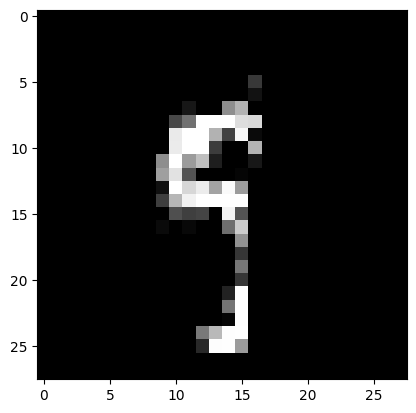

In [29]:
from cirkit.backend.torch.queries import SamplingQuery
circuit = compile(circuits["patch + cp.T + quad-graph"]).cpu()
query = SamplingQuery(circuit)

samples, _ = query(num_samples=1)
img = samples.reshape((28,28,1))
plt.imshow(img, cmap="grey")

In [ ]:
circuit.modules

TypeError: 'method' object is not subscriptable